### 4 Objects Classification

In [85]:
# importing libraries
import math
import tensorflow as tf
import keras
from keras.layers import *
import numpy as np
import random
import io
import os
from sklearn.model_selection import train_test_split
from keras.activations import tanh, softmax, sigmoid
from keras.applications.inception_resnet_v2 import InceptionResNetV2
import tensorflow as tf
import random
import os
import keras
import matplotlib.pyplot as plt
import pandas as pd
from keras.layers import (
    LSTM,
    LSTMCell,
    Input,
    Dense,
    concatenate,
    TimeDistributed,
    Flatten,
    Dropout,
    Masking,
    RepeatVector,
    GlobalAveragePooling2D,
    GlobalMaxPooling2D,
    Reshape,
    multiply,
    Permute,
    Concatenate,
    Conv2D,
    Add,
    Activation,
    Lambda,
    BatchNormalization
)
from keras import backend as K, Model
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score

In [86]:
# List all physical GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)

if gpus:
    try:
        # Select the first GPU (index 0)
        tf.config.set_visible_devices(gpus[5], 'GPU')

        # Optionally, limit GPU memory growth (prevents TensorFlow from consuming all GPU memory)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        print("Using GPU:", gpus[5])
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU')]
Using GPU: PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU')


In [87]:
# hard objects
plate = np.asarray([1, 0, 0, 0])
# soft objects
phone_cover = np.asarray([0, 1, 0, 0])
bottle = np.asarray([0, 0, 1, 0])
soft_rubber = np.asarray([0, 0, 0, 1])

In [88]:
encoded_objects = [plate, phone_cover, bottle, soft_rubber]

In [89]:
encoded_objects

[array([1, 0, 0, 0]),
 array([0, 1, 0, 0]),
 array([0, 0, 1, 0]),
 array([0, 0, 0, 1])]

In [90]:
# reading a numpy file
data_dir = './train_val_data'
samples_per_window = 30

def read_npy_files(directory):
  data = []
  labels = []
  i = 0
  for filename in os.listdir(directory):
    if filename.endswith(".npy"):
      base_name = os.path.splitext(filename)[0]
      data.append(np.load(os.path.join(directory, filename), allow_pickle = True))
      # for labelling objects = ['plate', 'ball', 'cover', 'bottle', 'soft_rubber']
      if 'plate' in filename :
          labels.append(np.tile(encoded_objects[0], (samples_per_window, 1)))
      elif 'phone' in filename and 'cover' in filename :
          labels.append(np.tile(encoded_objects[1], (samples_per_window, 1)))
      elif 'bottle' in filename :
          labels.append(np.tile(encoded_objects[2], (samples_per_window, 1)))
      elif 'rubber' in filename :
          labels.append(np.tile(encoded_objects[3], (samples_per_window, 1)))
  return data, labels

all_data, labels = read_npy_files(data_dir)

# converting to numpy array
all_data = np.asarray(all_data)[:, :, :, 1:].astype(np.float32)
labels = np.asarray(labels).astype(np.float32)

In [91]:
all_data.shape

(12, 8, 30, 3)

In [92]:
labels.shape

(12, 30, 4)

Spitting of the train and val dataset

In [93]:
train_all_data = []
val_all_data = []
test_all_data =[]
train_labels = []
val_labels = []
test_labels = []
total_samples = 8
val_samples = 1
test_samples = 1
train_samples = total_samples - val_samples - test_samples


for data in all_data:
  for i in range(train_samples):
    train_all_data.append(data[i])
  for i in range(val_samples):
    val_all_data.append(data[train_samples + i])
  for i in range(test_samples):
    test_all_data.append(data[train_samples + val_samples + i])

for label in labels:
  # label = np.expand_dims(label[1, :], axis = 0)
  # print(np.asarray(label).shape)
  for i in range(train_samples):
    train_labels.append(label[1, :])
  for i in range(val_samples):
    val_labels.append(label[1, :])
  for i in range(test_samples):
    test_labels.append(label[1, :])

In [94]:
# hyperpaprametres
TIME_STEPS = 30
input_dim  = 3
output_dim = 4

# UNITS_DENSE = 128
UNITS_LSTM = 1024

# DROPOUT_STRENGTH = 0.2
RECURRENT_DROPOUT_STRENGTH = 0.4

BIAS_INITIALIZER = "ones"
KERNEL_INITIALIZER = "VarianceScaling"

In [95]:
class LSTM_cell:
    def __init__(self, time_steps = TIME_STEPS,
                 dim_2 = input_dim,
                 lstm_units=UNITS_LSTM,
                 rec_dropout=RECURRENT_DROPOUT_STRENGTH,
                 kernel_initializer=KERNEL_INITIALIZER,
                 bias_initializer=BIAS_INITIALIZER):

        self.time_steps = time_steps
        self.dim_2 = dim_2
        self.rec_dropout = rec_dropout
        self.bias_initializer = bias_initializer
        self.kernel_initializer = kernel_initializer
        self.lstm_units = lstm_units

    def input_encoding_lstm(self, inputs):
        lstm_input = inputs
        lstm_hidden_states, hidden_state, _ = LSTM(
            self.lstm_units,
            kernel_initializer = self.kernel_initializer,
            return_sequences=True,
            return_state=True,
            recurrent_dropout=self.rec_dropout,
            bias_initializer=self.bias_initializer,
            name='lstm_output'
        )(lstm_input)

        context_features = Dense(output_dim)(hidden_state)
        out = softmax(context_features, axis = 1)
        return out

    def generate(self):
        input_to_lstm = Input(shape=(self.time_steps, self.dim_2), name='lstm_input')

        output_from_lstm = self.input_encoding_lstm(input_to_lstm)
        model = Model(inputs = input_to_lstm, outputs = output_from_lstm)
        return model

In [96]:
lstm = LSTM_cell()
model = lstm.generate()

In [97]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_input (InputLayer)         │ (None, 30, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_output (LSTM)              │ [(None, 30, 1024),     │     4,210,688 │
│                                 │ (None, 1024), (None,   │               │
│                                 │ 1024)]                 │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │         4,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_6 (Softmax)             │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,788 (16.08 MB)

 Trainable params: 4,214,788 (16.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2639 - f1_score: 0.0000e+00 - loss: 1.4645 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00
Epoch 1: val_f1_score improved from -inf to 0.22222, saving model to checkpoint_4obj_model.keras

Epoch 1: Learning Rate = 0.0010000000474974513
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.2639 - f1_score: 0.0000e+00 - loss: 1.4645 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_accuracy: 0.3333 - val_f1_score: 0.2222 - val_loss: 1.6631 - val_precision_6: 0.3333 - val_recall_6: 0.1667
Epoch 2/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.3056 - f1_score: 0.2202 - loss: 1.7012 - precision_6: 0.3243 - recall_6: 0.1667
Epoch 2: val_f1_score did not improve from 0.22222

Epoch 2: Learning Rate = 0.0010000000474974513
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.3056 - f1_score: 0.2202 - loss: 1.7012 - precision_6: 0.3243 - recall_6: 0.1667 - val_accuracy: 0.4167 - val_f1_score: 0.0000e+00 - val_loss: 1.301

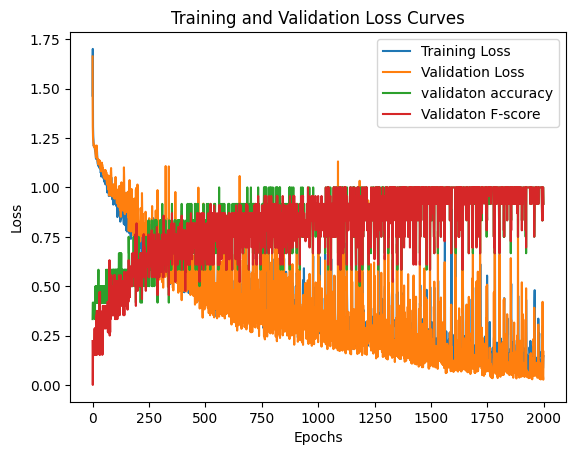

In [98]:
checkpoint_filepath = 'checkpoint_4obj_model.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor = 'val_f1_score',
    mode = 'max',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False)

precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

def f1_score(y_true, y_pred):
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    f1 = 2 * ((precision_value * recall_value) / (precision_value + recall_value + tf.keras.backend.epsilon()))
    return f1

# Early stopping criteria
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3)

initial_lr = 1e-3
decay_rate = 0.5
# val_acc_list = np.asarray(history.history['val_accuracy'])
# max_val_acc = (val_acc_list).max()
# print(max_val_acc, np.where(val_acc_list == max_val_acc)[0] + 1)
optimizer = keras.optimizers.Adam(learning_rate = initial_lr)

model.compile( loss = 'categorical_crossentropy', metrics = ['accuracy', precision, recall, f1_score])

class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(MetricsCallback, self).__init__()
        self.validation_data = validation_data
    def on_epoch_end(self, epoch, logs = None):
        lr = self.model.optimizer.learning_rate
        print(f"\nEpoch {epoch + 1}: Learning Rate = {lr.numpy()}")

class ReduceLROnPlateau(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        # Decrease learning rate by 0.1 after each epoch
        lr = float(K.get_value(optimizer.learning_rate))
        if lr > 3.4e-44:
            lr = lr * 0.1
        K.set_value(optimizer.learning_rate, lr)
        print(f"\nEpoch {epoch + 1}: New Learning Rate = {lr}")

# converting the numpy arrays into tensor
train_data_tf = tf.convert_to_tensor(train_all_data)
train_labels_tf = tf.convert_to_tensor(train_labels)
val_data_tf = tf.convert_to_tensor(val_all_data)
val_labels_tf = tf.convert_to_tensor(val_labels)
validation_data = (val_data_tf, val_labels_tf)

# training and validating step
history = model.fit(train_data_tf, train_labels_tf, epochs = 2000, batch_size = 128,
          validation_data = validation_data, callbacks = [model_checkpoint_callback, MetricsCallback(validation_data)])

# for tracking the maximum validation accuracy ata particular epoch
# val_acc_list = np.asarray(history.history['val_accuracy'])
# max_val_acc = (val_acc_list).max()
# print(max_val_acc, np.where(val_acc_list == max_val_acc)[0] + 1)

# plotting the graph
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['val_accuracy'], label='validaton accuracy')
plt.plot(history.history['val_f1_score'], label='Validaton F-score')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()